# Fine-tuning EpiAgent for data imputation on a newly-sequenced dataset
In this notebook, we provide a comprehensive demonstration of how to fine-tune the **EpiAgent** model for **data imputation** on a newly sequenced single-cell ATAC-seq dataset. The EpiAgent model has been pre-trained on the large-scale **Human-scATAC-Corpus**, comprising approximately **5 million cells** and **35 billion tokens**. By fine-tuning the pre-trained model on your dataset, you can enhance its performance for downstream analysis tasks specific to your data, particularly for imputation tasks such as filling missing or incomplete data points in single-cell ATAC-seq datasets.

**Prerequisites:**
- **EpiAgent Pre-trained Model**: `pretrained_EpiAgent.pth` (can be downloaded from [here](https://drive.google.com/drive/folders/1WlNykSCNtZGsUp2oG0dw3cDdVKYDR-iX?usp=sharing))
- **Candidate cis-Regulatory Elements (cCREs)**: `cCRE.bed` (can be downloaded from [here](https://github.com/xy-chen16/EpiAgent/blob/main/data/cCRE.bed))
- **Sample Dataset**:`Kanemaru2023_downsampled_10000_cells.h5ad` (can be downloaded from [here](https://drive.google.com/drive/folders/1WlNykSCNtZGsUp2oG0dw3cDdVKYDR-iX?usp=sharing)): The downsampled Kanemaru2023 dataset.


# Step 1: Data Loading and Preprocessing
In this step, we will load the `Kanemaru2023_downsampled_10000_cells.h5ad` dataset and perform necessary preprocessing to prepare it for fine-tuning with EpiAgent. The preprocessing involves converting raw count data into TF-IDF scores and tokenizing the data to create cell sentences.
## Preprocessing Steps:
1. **TF-IDF Transformation**: Convert discrete count data into continuous importance scores for accessible cCREs.
2. **Tokenization**: Generate `cell_sentences` to represent each cell as a sequence of accessible cCRE indices.


In [1]:
import scanpy as sc
import numpy as np
from epiagent.tokenization import tokenization
from epiagent.preprocessing import global_TFIDF

# Load the raw dataset
input_path = '../data/sample/raw_h5ad/Kanemaru2023_downsampled_10000_cells.h5ad'
adata = sc.read_h5ad(input_path)

# Load the cCRE document frequency data
cCRE_document_frequency = np.load('../data/cCRE_document_frequency.npy')

# Apply TF-IDF transformation
global_TFIDF(adata, cCRE_document_frequency)

# Perform tokenization to create cell sentences
tokenization(adata)

Tokenization complete: 'cell_sentences' column added to adata.obs.


# Step 2: Create Datasets and DataLoaders
In this step, we create PyTorch datasets and dataloaders required for training and inference. We use different dataset classes for training (`CellDatasetForDI`) and inference (`CellDataset`).


## Creating Training Dataset and DataLoader
We use the `CellDatasetForDI` class to prepare the dataset for fine-tuning, which requires both the cCRE indices and the signal information from `adata`.


In [2]:
from epiagent.dataset import CellDatasetForDI, collate_fn_for_DI
from torch.utils.data import DataLoader

# Extract cell sentences from the AnnData object
cell_sentences = adata.obs['cell_sentences'].tolist()

# Create the training dataset
train_cell_dataset = CellDatasetForDI(
    adata=adata,
    cell_sentences=cell_sentences,
    max_length=8192,
    alpha_for_CCA=1,
    num_cCRE=1355445,
    is_random=False
)

# Create the training DataLoader
train_batch_size = 5
train_dataloader = DataLoader(
    train_cell_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=16,
    collate_fn=collate_fn_for_DI
)

## Creating Inference Dataset and DataLoader
For inference, we use the `CellDataset` class, which only requires the tokenized cell sentences.


In [3]:
from epiagent.dataset import CellDataset, collate_fn

# Create the inference dataset
inference_cell_dataset = CellDataset(
    cell_sentences=cell_sentences,
    max_length=8192,
    is_random=False
)

# Create the inference DataLoader
inference_batch_size = 8
inference_dataloader = DataLoader(
    inference_cell_dataset,
    batch_size=inference_batch_size,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

# Step 3: Load the Pre-trained EpiAgent Model
We load the pre-trained EpiAgent model, which was trained on the Human-scATAC-Corpus, and prepare it for fine-tuning.


In [5]:
from epiagent.model import EpiAgent
import torch
import torch.nn as nn

# Specify the path to the pre-trained model
model_path = '../model/pretrained_EpiAgent.pth'

# Set the device (GPU if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the EpiAgent model with appropriate configurations
pretrained_model = EpiAgent(
    vocab_size=1355449,
    num_layers=18,
    embedding_dim=512,
    num_attention_heads=8,
    max_rank_embeddings=8192,
    use_flash_attn=True,
    pos_weight_for_RLM=torch.tensor(1.),
    pos_weight_for_CCA=torch.tensor(1.)
)

# Load the pre-trained weights into the model
pretrained_model.load_state_dict(torch.load(model_path))

# Set criterion for signal reconstruction (SR)
pretrained_model.criterion_SR = nn.MSELoss()

# Move the model to the specified device
pretrained_model.to(device)

EpiAgent(
  (cCRE_embedding): Embedding(1355449, 512)
  (rank_embedding): Embedding(8192, 512)
  (EpiAgent_transformer): BertEncoder(
    (layers): ModuleList(
      (0-17): 18 x Block(
        (mixer): MHA(
          (Wqkv): LinearResidual(in_features=512, out_features=1536, bias=True)
          (inner_attn): FlashSelfAttention(
            (drop): Dropout(p=0.1, inplace=False)
          )
          (inner_cross_attn): FlashCrossAttention(
            (drop): Dropout(p=0.1, inplace=False)
          )
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (drop_path1): StochasticDepth(p=0.0, mode=row)
        (norm1): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout2): Dropout(p=0.1, inplace=False)
        (d

# Step 4: Fine-tuning the EpiAgent Model
We now fine-tune the pre-trained EpiAgent model using the prepared training data. The fine-tuning process adjusts the model weights to better capture the patterns specific to the new dataset.
Note: Even though this process refers to unsupervised feature extraction (UFE) in the original documentation, we are using the same fine-tuning function for **data imputation (DI)** since the only difference is the use of **signal reconstruction loss (SR)**.


In [6]:
from epiagent.train import fine_tune_epiagent_for_UFE

# Fine-tune the model
fine_tuned_model = fine_tune_epiagent_for_UFE(
    model=pretrained_model,
    train_dataloader=train_dataloader,
    num_steps=200000, 
    save_dir='../model/fine_tune/DI/demo_dataset/',
    device=device,
    learning_rate=1e-4,
    save_steps=20000,
    log_steps=500,
    warmup_steps=10000,
    is_logging=True
)

Model directory created at: ../model/fine_tune/DI/demo_dataset/


/home/chenxiaoyang/anaconda3/envs/FM/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
Epoch [1/19], Step [500/2001], Total Loss: 5.9551, CCA Loss: 1.8980, SR Loss: 4.0571
CCA Metrics - Positive Acc: 0.6495, Negative Acc: 0.8308, AUROC: 0.8119, AUPRC: 0.8891
Epoch [1/19], Step [1000/2001], Total Loss: 3.9707, CCA Loss: 1.7574, SR Loss: 2.2133
CCA Metrics - Positive Acc: 0.5950, Negative Acc: 0.7733, AUROC: 0.7358, AUPRC: 0.8646
Epoch [1/19], Step [1500/2001], Total Loss: 2.3454, CCA Loss: 1.5348, SR Loss: 0.

# Step 5: Extract Imputed Signals Using the Fine-tuned Model
In this step, we first determine the top 50,000 candidate cis-regulatory elements (cCREs) with the highest accessibility. Since the full set of 1,355,445 cCREs would produce an extremely large cell-by-cCRE matrix, for demonstration purposes we focus on the 50,000 most accessible cCREs. These indices are passed as a parameter to the infer_reconstructed_signals function. This function then outputs the predicted (imputed) signals for each cell for the selected subset of cCREs.

In [10]:
import numpy as np
from epiagent.inference import infer_reconstructed_signals

# Compute the overall accessibility for each cCRE by summing across all cells.
# Note: adata.X can be a sparse matrix; convert it to dense if needed.
cCRE_accessibility = np.array(adata.X.sum(axis=0)).squeeze()

# Get the indices for the top 50,000 most accessible cCREs.
top_50000_indices = np.argsort(cCRE_accessibility)[-50000:]

# Call the inference function using the fine-tuned model.
# We pass the top_50000_indices to restrict the predictions to these cCREs.
outputs = infer_reconstructed_signals(
    model=fine_tuned_model,
    device=device,
    dataloader=inference_dataloader,
    need_cell_embeddings=False,         # Set to True if you also need cell embeddings.
    predicted_cCRE_indices=top_50000_indices  # Only predict the top 50,000 cCREs.
)

# The predicted_signals matrix now has shape (num_cells, 50000)
predicted_signals = outputs['predicted_signals']

# Step 6: Visual Comparison Before and After Data Imputation

In this step, we compare the results of data imputation by visualizing the cell clustering in a low-dimensional space using PCA and UMAP. 
Note: 

•	Since the complete cell-by-cCRE matrix is extremely large (1,355,445 features), for this demonstration we only focus on the top 50,000 most accessible cCREs.

•	We create two AnnData objects:

    1. One where we subset the original dataset to the top 50,000 cCREs.
    2. A new object where the imputed (predicted) signals replace the original data for these top 50,000 cCREs.

We then run PCA, compute neighbors, and generate a UMAP embedding on both objects and plot the results using the cell_type labels.


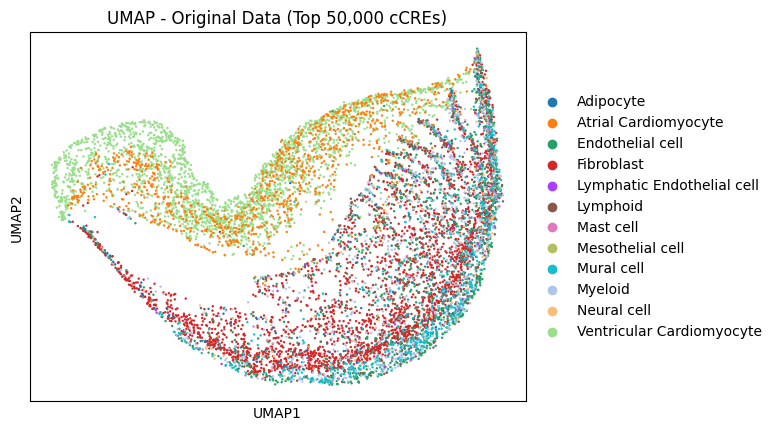

... storing 'cell_type' as categorical


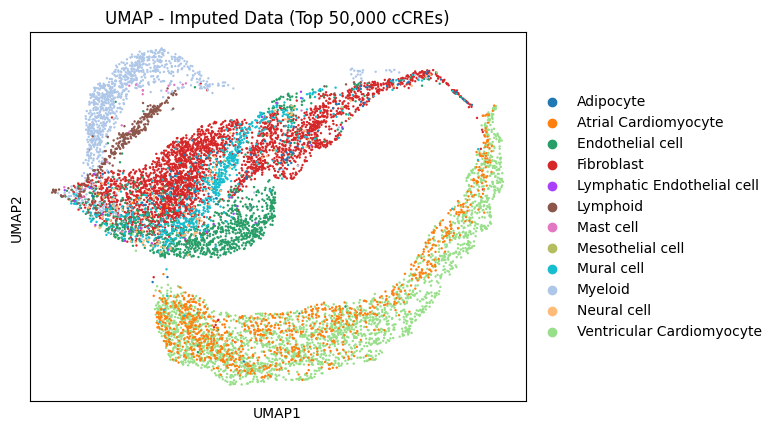

In [12]:
import scanpy as sc
import anndata as ad

# ----- Prepare the Original Data Subset -----
# Create a new AnnData object for the original data using only the top 50,000 cCREs.
original_adata_top = sc.AnnData(adata.X[:, top_50000_indices])
original_adata_top.obs = adata.obs

# Preprocess the original subset: scale, compute PCA, compute neighbors, and run UMAP.
# sc.pp.scale(original_adata_top)
sc.tl.pca(original_adata_top, n_comps=50)
sc.pp.neighbors(original_adata_top, n_neighbors=15)
sc.tl.umap(original_adata_top)

# Visualize the original data UMAP colored by cell type.
sc.pl.umap(original_adata_top, color='cell_type', title="UMAP - Original Data (Top 50,000 cCREs)")

# ----- Prepare the Imputed Data Object -----
# Create a new AnnData object for the imputed signals.
imputed_adata = sc.AnnData(predicted_signals)
imputed_adata.obs = adata.obs

# Make sure the cell_type information is preserved.
imputed_adata.obs['cell_type'] = adata.obs['cell_type'].tolist()

# Preprocess the imputed data: scale, compute PCA, compute neighbors, and run UMAP.
# sc.pp.scale(imputed_adata)
sc.tl.pca(imputed_adata, n_comps=50)
sc.pp.neighbors(imputed_adata, n_neighbors=15)
sc.tl.umap(imputed_adata)

# Visualize the imputed data UMAP colored by cell type.
sc.pl.umap(imputed_adata, color='cell_type', title="UMAP - Imputed Data (Top 50,000 cCREs)")

## Optional: Save the Processed AnnData Object

You may choose to save the `AnnData` object with the imputed signals for future analysis.

In [14]:
# Save the processed AnnData
output_path = '../data/sample/processed_h5ad/Kanemaru2023_downsampled_10000_cells_EpiAgent_imputed_signals_top_50000_accessible_cCREs.h5ad'
imputed_adata.write(output_path)
print(f"Processed AnnData saved at {output_path}")

Processed AnnData saved at ../data/sample/processed_h5ad/Kanemaru2023_downsampled_10000_cells_EpiAgent_imputed_signals_top_50000_accessible_cCREs.h5ad
